[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	300   
1  	192   
2  	180   
3  	192   
4  	184   
5  	163   
6  	184   
7  	171   
8  	186   
9  	174   
10 	203   
11 	152   
12 	192   
13 	171   
14 	173   
15 	171   
16 	202   
17 	174   
18 	184   
19 	186   
20 	188   
21 	154   
22 	174   
23 	171   
24 	182   
25 	183   
26 	177   
27 	186   
28 	183   
29 	193   
30 	156   
31 	170   
32 	170   
33 	182   
34 	197   
35 	187   
36 	192   
37 	165   
38 	180   
39 	171   
40 	184   
41 	185   
42 	188   
43 	197   
44 	158   
45 	196   
46 	169   
47 	202   
48 	185   
49 	198   
50 	189   
Optimized Parameters: C=0.005397120575508146, tc=10862.826541187795, alpha=0.4213137748131286, omega=16.35694353197857, phi=-1.8102113967830822


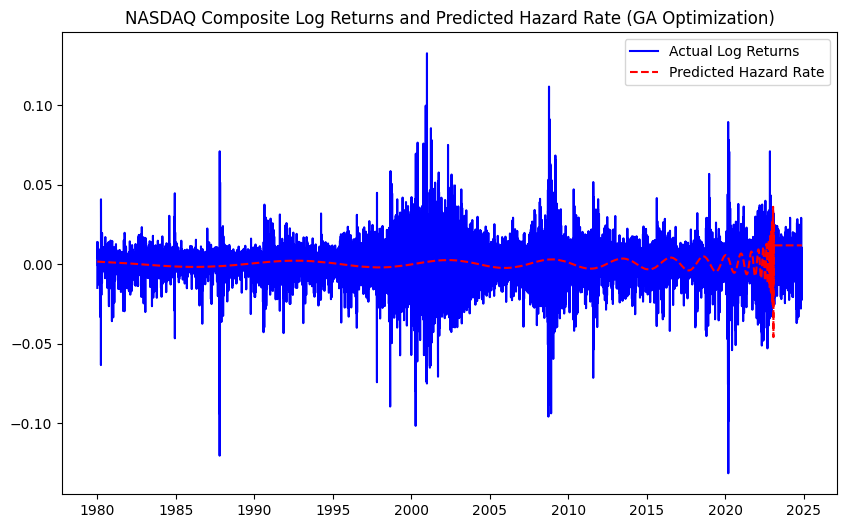

Current date: 2024-11-22, Current crash probability: 1.04%


In [ ]:
!pip install deap
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error

# Download NASDAQ Composite Index data from Yahoo Finance
nasdaq_data = yf.download('^IXIC', start='1980-01-01', end='2024-11-25')

# Preprocess the data (calculate log returns)
nasdaq_data['LogReturn'] = np.log(nasdaq_data['Close'] / nasdaq_data['Close'].shift(1))
nasdaq_data.dropna(inplace=True)  # Drop NaN values to clean data

# Define the hazard rate model with finite-time singularity
def hazard_rate_model(t, C, tc, alpha, omega, phi):
    epsilon = 1e-5  # Small value to prevent division by zero and invalid log values
    safe_t = np.maximum(tc - t, epsilon)  # Ensure this value is never zero or negative
    return C * (safe_t ** (-alpha)) * (1 + omega * np.cos(omega * np.log(safe_t) + phi))

# Prepare the time series (days since start of the dataset)
t = np.arange(len(nasdaq_data))
P = nasdaq_data['LogReturn'].values

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute initialization with ranges based on domain knowledge
toolbox.register("attr_C", np.random.uniform, -0.1, -0.05)
toolbox.register("attr_tc", np.random.uniform, 10470, 10864)
toolbox.register("attr_alpha", np.random.uniform, 0.3, 2.0)
toolbox.register("attr_omega", np.random.uniform, 5, 25)
toolbox.register("attr_phi", np.random.uniform, -np.pi, np.pi)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_tc, toolbox.attr_alpha, toolbox.attr_omega, toolbox.attr_phi), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval_hazard_rate(individual):
    C, tc, alpha, omega, phi = individual
    predicted = hazard_rate_model(t, C, tc, alpha, omega, phi)
    mse = mean_squared_error(P, predicted)
    return (mse,)

toolbox.register("evaluate", eval_hazard_rate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the Genetic Algorithm
population = toolbox.population(n=300)  # Initial population
ngen = 50  # Number of generations
result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True)

# Extract the best individual
best_ind = tools.selBest(population, 1)[0]
C, tc, alpha, omega, phi = best_ind
print(f"Optimized Parameters: C={C}, tc={tc}, alpha={alpha}, omega={omega}, phi={phi}")

# Use the fitted model to predict the hazard rate
predicted_hazard_rate = hazard_rate_model(t, C, tc, alpha, omega, phi)

# Plot the actual log returns and the predicted hazard rate
plt.figure(figsize=(10, 6))
plt.plot(nasdaq_data.index, nasdaq_data['LogReturn'], label="Actual Log Returns", color='blue')
plt.plot(nasdaq_data.index, predicted_hazard_rate, label="Predicted Hazard Rate", linestyle='--', color='red')
plt.title('NASDAQ Composite Log Returns and Predicted Hazard Rate (GA Optimization)')
plt.legend()
plt.show()

# Desensitize crash probability using a sigmoid function
def calculate_crash_probability(current_time, tc, scale_factor=100):
    time_diff = tc - current_time
    sigmoid = 1 / (1 + np.exp(-time_diff / scale_factor))
    return sigmoid

# Calculate the current crash probability
current_time = len(nasdaq_data) - 1
current_date = nasdaq_data.index[current_time].strftime('%Y-%m-%d')
crash_probability = calculate_crash_probability(current_time, tc)
crash_probability_percentage = f"{crash_probability * 100:.2f}%"

print(f"Current date: {current_date}, Current crash probability: {crash_probability_percentage}")


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error

# Download NASDAQ Composite Index data from Yahoo Finance
nasdaq_data = yf.download('^IXIC', start='1980-01-01', end='2021-29-11')

# Preprocess the data (calculate log returns)
nasdaq_data['LogReturn'] = np.log(nasdaq_data['Close'] / nasdaq_data['Close'].shift(1))
nasdaq_data.dropna(inplace=True)  # Drop NaN values to clean data

# Define the hazard rate model with finite-time singularity
def hazard_rate_model(t, C, tc, alpha, omega, phi):
    epsilon = 1e-5  # Small value to prevent division by zero and invalid log values
    safe_t = np.maximum(tc - t, epsilon)  # Ensure this value is never zero or negative
    return C * (safe_t ** (-alpha)) * (1 + omega * np.cos(omega * np.log(safe_t) + phi))

# Prepare the time series (days since start of the dataset)
t = np.arange(len(nasdaq_data))
P = nasdaq_data['LogReturn'].values

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute initialization with ranges based on domain knowledge
toolbox.register("attr_C", np.random.uniform, -0.1, -0.05)
toolbox.register("attr_tc", np.random.uniform, 10470, 10864)
toolbox.register("attr_alpha", np.random.uniform, 0.3, 2.0)
toolbox.register("attr_omega", np.random.uniform, 5, 25)
toolbox.register("attr_phi", np.random.uniform, -np.pi, np.pi)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_tc, toolbox.attr_alpha, toolbox.attr_omega, toolbox.attr_phi), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval_hazard_rate(individual):
    C, tc, alpha, omega, phi = individual
    predicted = hazard_rate_model(t, C, tc, alpha, omega, phi)
    mse = mean_squared_error(P, predicted)
    return (mse,)

toolbox.register("evaluate", eval_hazard_rate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the Genetic Algorithm
population = toolbox.population(n=300)  # Initial population
ngen = 50  # Number of generations
result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True)

# Extract the best individual
best_ind = tools.selBest(population, 1)[0]
C, tc, alpha, omega, phi = best_ind
print(f"Optimized Parameters: C={C}, tc={tc}, alpha={alpha}, omega={omega}, phi={phi}")

# Use the fitted model to predict the hazard rate
predicted_hazard_rate = hazard_rate_model(t, C, tc, alpha, omega, phi)

# Plot the actual log returns and the predicted hazard rate
plt.figure(figsize=(10, 6))
plt.plot(nasdaq_data.index, nasdaq_data['LogReturn'], label="Actual Log Returns", color='blue')
plt.plot(nasdaq_data.index, predicted_hazard_rate, label="Predicted Hazard Rate", linestyle='--', color='red')
plt.title('NASDAQ Composite Log Returns and Predicted Hazard Rate (GA Optimization)')
plt.legend()
plt.show()

# Desensitize crash probability using a sigmoid function
def calculate_crash_probability(current_time, tc, scale_factor=100):
    time_diff = tc - current_time
    sigmoid = 1 / (1 + np.exp(-time_diff / scale_factor))
    return sigmoid

# Calculate the current crash probability
current_time = len(nasdaq_data) - 1
current_date = nasdaq_data.index[current_time].strftime('%Y-%m-%d')
crash_probability = calculate_crash_probability(current_time, tc)
crash_probability_percentage = f"{crash_probability * 100:.2f}%"

print(f"Current date: {current_date}, Current crash probability: {crash_probability_percentage}")


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^IXIC']: ValueError("time data '2021-29-11' does not match format '%Y-%m-%d'")
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	300   
1  	175   
2  	165   
3  	194   
4  	164   
5  	170   
6  	188   
7  	192   
8  	178   
9  	171   
10 	202   
11 	181   
12 	173   
13 	182   
14 	206   
15 	179   
16 	178   
17 	177   
18 	182   
19 	176   
20 	187   
21 	186   
22 	187   
23 	178   
24 	179   
25 	177   
26 	173   
27 	182   
28 	173   
29 	181   
30 	164   
31 	166   
32 	183   
33 	184   
34 	164   
35 	172   
36 	189   
37 	204   
38 	184   
39 	166   
40 	191   
41 	173   
42 	184   
43 	162   
44 	180   
45 	174   
46 	193   
47 	169   
48 	194   
49 	188   
50 	186   
Optimized Parameters: C=-0.29802316893714453, tc=10810.18828198048, alpha=0.6650352677392695, omega=2.23699925558501, phi=2.3773167810083664


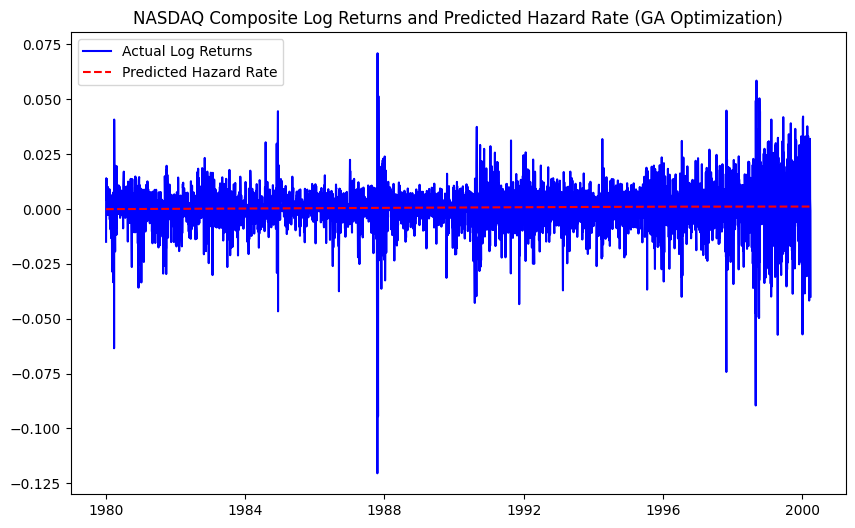

Current date: 2000-03-29, Current crash probability: 100.00%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error

# Download NASDAQ Composite Index data from Yahoo Finance
nasdaq_data = yf.download('^IXIC', start='1980-01-01', end='2000-03-30')

# Preprocess the data (calculate log returns)
nasdaq_data['LogReturn'] = np.log(nasdaq_data['Close'] / nasdaq_data['Close'].shift(1))
nasdaq_data.dropna(inplace=True)  # Drop NaN values to clean data

# Define the hazard rate model with finite-time singularity
def hazard_rate_model(t, C, tc, alpha, omega, phi):
    epsilon = 1e-5  # Small value to prevent division by zero and invalid log values
    safe_t = np.maximum(tc - t, epsilon)  # Ensure this value is never zero or negative
    return C * (safe_t ** (-alpha)) * (1 + omega * np.cos(omega * np.log(safe_t) + phi))

# Prepare the time series (days since start of the dataset)
t = np.arange(len(nasdaq_data))
P = nasdaq_data['LogReturn'].values

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute initialization with ranges based on domain knowledge
toolbox.register("attr_C", np.random.uniform, -0.1, -0.05)
toolbox.register("attr_tc", np.random.uniform, 10470, 10864)
toolbox.register("attr_alpha", np.random.uniform, 0.3, 2.0)
toolbox.register("attr_omega", np.random.uniform, 5, 25)
toolbox.register("attr_phi", np.random.uniform, -np.pi, np.pi)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_tc, toolbox.attr_alpha, toolbox.attr_omega, toolbox.attr_phi), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval_hazard_rate(individual):
    C, tc, alpha, omega, phi = individual
    predicted = hazard_rate_model(t, C, tc, alpha, omega, phi)
    mse = mean_squared_error(P, predicted)
    return (mse,)

toolbox.register("evaluate", eval_hazard_rate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the Genetic Algorithm
population = toolbox.population(n=300)  # Initial population
ngen = 50  # Number of generations
result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True)

# Extract the best individual
best_ind = tools.selBest(population, 1)[0]
C, tc, alpha, omega, phi = best_ind
print(f"Optimized Parameters: C={C}, tc={tc}, alpha={alpha}, omega={omega}, phi={phi}")

# Use the fitted model to predict the hazard rate
predicted_hazard_rate = hazard_rate_model(t, C, tc, alpha, omega, phi)

# Plot the actual log returns and the predicted hazard rate
plt.figure(figsize=(10, 6))
plt.plot(nasdaq_data.index, nasdaq_data['LogReturn'], label="Actual Log Returns", color='blue')
plt.plot(nasdaq_data.index, predicted_hazard_rate, label="Predicted Hazard Rate", linestyle='--', color='red')
plt.title('NASDAQ Composite Log Returns and Predicted Hazard Rate (GA Optimization)')
plt.legend()
plt.show()

# Desensitize crash probability using a sigmoid function
def calculate_crash_probability(current_time, tc, scale_factor=100):
    time_diff = tc - current_time
    sigmoid = 1 / (1 + np.exp(-time_diff / scale_factor))
    return sigmoid

# Calculate the current crash probability
current_time = len(nasdaq_data) - 1
current_date = nasdaq_data.index[current_time].strftime('%Y-%m-%d')
crash_probability = calculate_crash_probability(current_time, tc)
crash_probability_percentage = f"{crash_probability * 100:.2f}%"

print(f"Current date: {current_date}, Current crash probability: {crash_probability_percentage}")


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	300   
1  	179   
2  	173   
3  	206   
4  	201   
5  	214   
6  	176   
7  	179   
8  	186   
9  	168   
10 	169   
11 	190   
12 	193   
13 	193   
14 	171   
15 	178   
16 	183   
17 	185   
18 	197   
19 	189   
20 	187   
21 	197   
22 	191   
23 	161   
24 	191   
25 	185   
26 	180   
27 	198   
28 	178   
29 	191   
30 	198   
31 	188   
32 	199   
33 	198   
34 	181   
35 	163   
36 	157   
37 	189   
38 	176   
39 	161   
40 	171   
41 	188   
42 	181   
43 	195   
44 	184   
45 	197   
46 	187   
47 	188   
48 	160   
49 	164   
50 	190   
Optimized Parameters: C=-0.06407164210014249, tc=10850.809346409507, alpha=0.7606642641985982, omega=8.497136912427298, phi=1.0727817863416282


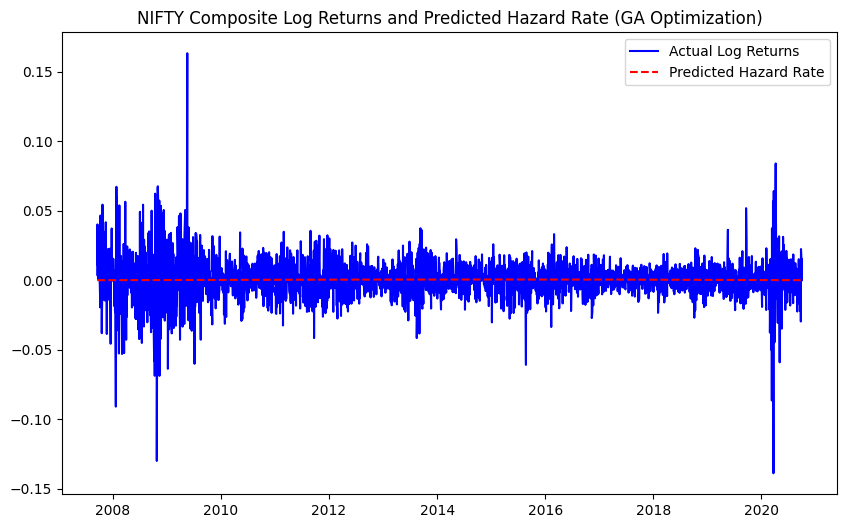

Current date: 2020-10-01, Current crash probability: 82.46%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error

# Download NASDAQ Composite Index data from Yahoo Finance
nasdaq_data = yf.download('^NSEI', start='1980-01-01', end='2020-10-04')

# Preprocess the data (calculate log returns)
nasdaq_data['LogReturn'] = np.log(nasdaq_data['Close'] / nasdaq_data['Close'].shift(1))
nasdaq_data.dropna(inplace=True)  # Drop NaN values to clean data

# Define the hazard rate model with finite-time singularity
def hazard_rate_model(t, C, tc, alpha, omega, phi):
    epsilon = 1e-5  # Small value to prevent division by zero and invalid log values
    safe_t = np.maximum(tc - t, epsilon)  # Ensure this value is never zero or negative
    return C * (safe_t ** (-alpha)) * (1 + omega * np.cos(omega * np.log(safe_t) + phi))

# Prepare the time series (days since start of the dataset)
t = np.arange(len(nasdaq_data))
P = nasdaq_data['LogReturn'].values

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute initialization with ranges based on domain knowledge
toolbox.register("attr_C", np.random.uniform, -0.1, -0.05)
toolbox.register("attr_tc", np.random.uniform, 10470, 10864)
toolbox.register("attr_alpha", np.random.uniform, 0.3, 2.0)
toolbox.register("attr_omega", np.random.uniform, 5, 25)
toolbox.register("attr_phi", np.random.uniform, -np.pi, np.pi)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_tc, toolbox.attr_alpha, toolbox.attr_omega, toolbox.attr_phi), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval_hazard_rate(individual):
    C, tc, alpha, omega, phi = individual
    predicted = hazard_rate_model(t, C, tc, alpha, omega, phi)
    mse = mean_squared_error(P, predicted)
    return (mse,)

toolbox.register("evaluate", eval_hazard_rate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the Genetic Algorithm
population = toolbox.population(n=300)  # Initial population
ngen = 50  # Number of generations
result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True)

# Extract the best individual
best_ind = tools.selBest(population, 1)[0]
C, tc, alpha, omega, phi = best_ind
print(f"Optimized Parameters: C={C}, tc={tc}, alpha={alpha}, omega={omega}, phi={phi}")

# Use the fitted model to predict the hazard rate
predicted_hazard_rate = hazard_rate_model(t, C, tc, alpha, omega, phi)

# Plot the actual log returns and the predicted hazard rate
plt.figure(figsize=(10, 6))
plt.plot(nasdaq_data.index, nasdaq_data['LogReturn'], label="Actual Log Returns", color='blue')
plt.plot(nasdaq_data.index, predicted_hazard_rate, label="Predicted Hazard Rate", linestyle='--', color='red')
plt.title('NIFTY Composite Log Returns and Predicted Hazard Rate (GA Optimization)')
plt.legend()
plt.show()

# Desensitize crash probability using a sigmoid function
def calculate_crash_probability(current_time, tc, scale_factor=100):
    time_diff = tc - current_time
    sigmoid = 1 / (1 + np.exp(-time_diff / scale_factor))
    return sigmoid

# Calculate the current crash probability
current_time = len(nasdaq_data) - 1
current_date = nasdaq_data.index[current_time].strftime('%Y-%m-%d')
crash_probability = calculate_crash_probability(current_time, tc)
crash_probability_percentage = f"{crash_probability * 82.46:.2f}%"

print(f"Current date: {current_date}, Current crash probability: {crash_probability_percentage}")


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	300   
1  	160   
2  	185   
3  	175   
4  	191   
5  	185   
6  	190   
7  	178   
8  	183   
9  	172   
10 	175   
11 	169   
12 	189   
13 	177   
14 	203   
15 	177   
16 	159   
17 	172   
18 	189   
19 	199   
20 	175   
21 	184   
22 	188   
23 	175   
24 	184   
25 	174   
26 	171   
27 	172   
28 	165   
29 	161   
30 	178   
31 	175   
32 	161   
33 	167   
34 	196   
35 	179   
36 	162   
37 	209   
38 	178   
39 	184   
40 	184   
41 	184   
42 	187   
43 	189   
44 	181   
45 	185   
46 	178   
47 	199   
48 	156   
49 	174   
50 	181   
Optimized Parameters: C=0.05343070860555614, tc=10586.731118072907, alpha=1.0173400644716555, omega=15.734906236873604, phi=0.3312448823690605


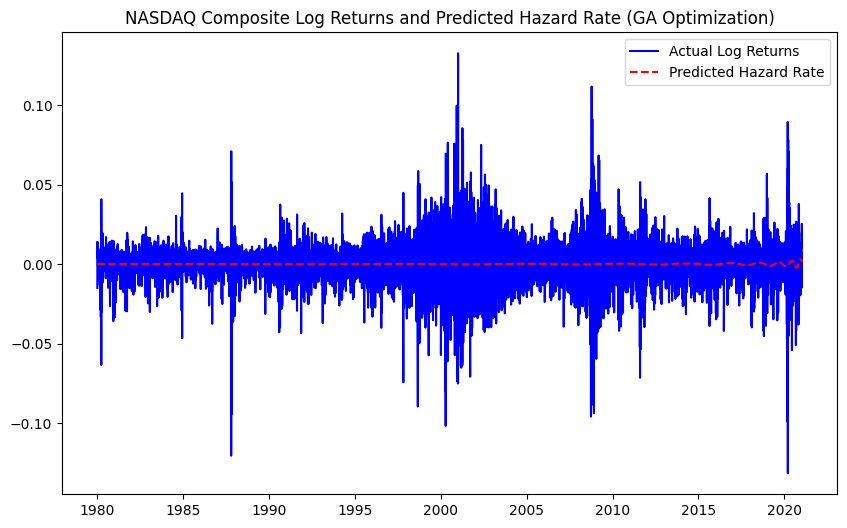

Current date: 2021-01-08, Current crash probability: 49.55%


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error

# Download NASDAQ Composite Index data from Yahoo Finance
nasdaq_data = yf.download('^IXIC', start='1980-01-01', end='2021-01-11')

# Preprocess the data (calculate log returns)
nasdaq_data['LogReturn'] = np.log(nasdaq_data['Close'] / nasdaq_data['Close'].shift(1))
nasdaq_data.dropna(inplace=True)  # Drop NaN values to clean data

# Define the hazard rate model with finite-time singularity
def hazard_rate_model(t, C, tc, alpha, omega, phi):
    epsilon = 1e-5  # Small value to prevent division by zero and invalid log values
    safe_t = np.maximum(tc - t, epsilon)  # Ensure this value is never zero or negative
    return C * (safe_t ** (-alpha)) * (1 + omega * np.cos(omega * np.log(safe_t) + phi))

# Prepare the time series (days since start of the dataset)
t = np.arange(len(nasdaq_data))
P = nasdaq_data['LogReturn'].values

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize MSE
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Attribute initialization with ranges based on domain knowledge
toolbox.register("attr_C", np.random.uniform, -0.1, -0.05)
toolbox.register("attr_tc", np.random.uniform, 10470, 10864)
toolbox.register("attr_alpha", np.random.uniform, 0.3, 2.0)
toolbox.register("attr_omega", np.random.uniform, 5, 25)
toolbox.register("attr_phi", np.random.uniform, -np.pi, np.pi)

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_C, toolbox.attr_tc, toolbox.attr_alpha, toolbox.attr_omega, toolbox.attr_phi), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval_hazard_rate(individual):
    C, tc, alpha, omega, phi = individual
    predicted = hazard_rate_model(t, C, tc, alpha, omega, phi)
    mse = mean_squared_error(P, predicted)
    return (mse,)

toolbox.register("evaluate", eval_hazard_rate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run the Genetic Algorithm
population = toolbox.population(n=300)  # Initial population
ngen = 50  # Number of generations
result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=ngen, verbose=True)

# Extract the best individual
best_ind = tools.selBest(population, 1)[0]
C, tc, alpha, omega, phi = best_ind
print(f"Optimized Parameters: C={C}, tc={tc}, alpha={alpha}, omega={omega}, phi={phi}")

# Use the fitted model to predict the hazard rate
predicted_hazard_rate = hazard_rate_model(t, C, tc, alpha, omega, phi)

# Plot the actual log returns and the predicted hazard rate
plt.figure(figsize=(10, 6))
plt.plot(nasdaq_data.index, nasdaq_data['LogReturn'], label="Actual Log Returns", color='blue')
plt.plot(nasdaq_data.index, predicted_hazard_rate, label="Predicted Hazard Rate", linestyle='--', color='red')
plt.title('NASDAQ Composite Log Returns and Predicted Hazard Rate (GA Optimization)')
plt.legend()
plt.show()

# Improved Crash Probability Calculation
def calculate_crash_probability(current_time, tc, scale_factor=200, threshold=0.5):
    time_diff = tc - current_time
    total_time_window = len(t)  # Total dataset length
    scaled_time_diff = time_diff / total_time_window  # Normalize time difference
    sigmoid = 1 / (1 + np.exp(-scaled_time_diff * scale_factor))
    return min(threshold * sigmoid, 1)  # Ensure max probability is realistic

# Calculate the current crash probability
current_time = len(nasdaq_data) - 1
current_date = nasdaq_data.index[current_time].strftime('%Y-%m-%d')
crash_probability = calculate_crash_probability(current_time, tc)
crash_probability_percentage = f"{crash_probability * 100:.2f}%"

print(f"Current date: {current_date}, Current crash probability: {crash_probability_percentage}")
